This notebook calculates the distance to the nearest 3 sigma molecular gas surface density value from the locations of each of the SNe located within 150pc maps.

In [1]:
#import packages and initialize settings
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.io import ascii
from astropy.table import Table
from progressbar import progressbar
from astropy.wcs import WCS
from reproject import reproject_interp

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
from FindNearestMC import nearestMCMethodSigMol

In [2]:
# Unpack master table to get SNe information
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")

database[0:1]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,PACovFile,IFRFile,MixedMaps,IFRResizedMaps,MassMaps
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str80,str112,str97,str37,str54,str35
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/ESO097-013_alphaCO21_scaling.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_coverage2d.fits,/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/z0mgs/eso097-013_w1_gauss7p5.fits,../Data/MixedMaps/circinus_Mixed.fits,../Data/ReprojectedInfraredMaps/circinus_reshaped.fits,../Data/MassMaps/circinus_Mass.fits


In [3]:
database.sort("galaxy")
gal_group = database.group_by("galaxy")
# print(len(gal_group))
# for i in range(len(gal_group)):
#     print(gal_group["SN_name"][i])

In [4]:
centerCoords = [(database["orient_ra"][i], database["orient_dec"][i]) for i in range(len(database))]    
SNe, SNra, SNdec  = database["SN_name"], database["SN_ra"], database["SN_dec"]
SNra  = np.array(SNra)
SNdec = np.array(SNdec)
# gal_group.groups.indices
# print(gal_group["galaxy"])

In [5]:
# remove duplicate galaxies, grouping SNe together in their own lists.

SNr, SNd, SNa = [],[],[]
gala, imgs, errs, alco, cocs, pans, incl, gdis, SNrs, SNdc, SNea = [],[],[],[],[],[],[],[],[],[],[]

for i in range(len(database)):
    gal = database["galaxy"][i]
    img = database["ImageFile150"][i]
    ers = database["ErrFile150"][i]
    aco = database["AlphaCOFile"][i]
    ccs = centerCoords[i]
    pas = database["orient_posang"][i]
    inc = database["orient_incl"][i]
    gds = database["dist"][i]
    SNr.append(SNra[i])
    SNd.append(SNdec[i])
    SNa.append(SNe[i])
    
    if (i+1) in gal_group.groups.indices:
#         print(i+1, gal, aco, SNr, SNd, SNa, ccs)
        gala.append(gal)
        imgs.append(img)
        errs.append(ers)
        alco.append(aco)
        cocs.append(ccs)
        pans.append(pas)
        incl.append(inc)
        gdis.append(gds)
        SNrs.append(SNr)
        SNdc.append(SNd)
        SNea.append(SNa) 
        SNr, SNd, SNa = [],[],[]
    else: pass

In [6]:
#Checking data
#for i in range(len(gal_group.groups.indices)-1):
# print(gala[3], imgs[3], alco[3])
# print(gdis)
# print(len(gala))
# print()

In [7]:
# calculate the distanct to the nearest pixel with a 3sigma value (nearestSigMol -> nSM)
# AND the sigma mol value (SMvalue -> SMv) at each SN site
nearestSigMol, SMvalue, threeSigCutoff = [],[],[]
for i in range(len(gala)):
    if incl[i] == 90.0:
        incl[i] = 80.0
    nearSM, SMval, threeSig = nearestMCMethodSigMol(gala[i], imgs[i], errs[i], alco[i], cocs[i], pans[i], incl[i], gdis[i], SNrs[i], SNdc[i], SNea[i])
    nearestSigMol.append(nearSM)
    SMvalue.append(SMval)
    threeSigCutoff.append(threeSig)

# combine list of arrays into single 1D list    
nSM = np.hstack(nearestSigMol)
SMv = np.hstack(SMvalue)
# remove negative values and nans
import math
nSM = [x for x in nSM if math.isnan(x) == False and x >= 0]
SMv = [x for x in SMv if math.isnan(x) == False and x >= 0]

Three Sigma Cutoff:  9.236361134765067
done with circinus  
Three Sigma Cutoff:  3.6035012600223624
done with ngc0253  
Three Sigma Cutoff:  8.380796894065606
done with ngc0628  
No file for  ngc1068
Three Sigma Cutoff:  9.946129750954542
done with ngc1087  
Three Sigma Cutoff:  6.738979939629368
done with ngc1097  
Three Sigma Cutoff:  10.060305538186467
done with ngc1365  
Three Sigma Cutoff:  7.4787886913570905
done with ngc1433  
Three Sigma Cutoff:  4.94147025870372
done with ngc1511  
Three Sigma Cutoff:  8.007132676825048
done with ngc1559  
Three Sigma Cutoff:  9.098568365668214
done with ngc1566  
Three Sigma Cutoff:  6.978112545096753
done with ngc1637  
No file for  ngc1672
Three Sigma Cutoff:  12.099181570193819
done with ngc2775  
Three Sigma Cutoff:  7.158763229087627
done with ngc2997  
Three Sigma Cutoff:  3.946877019781849
done with ngc3239  
Three Sigma Cutoff:  7.854528561726722
done with ngc3627  
Three Sigma Cutoff:  13.457167888040878
done with ngc4254  
Three Sig

/home/mayker.1/Desktop/PythonFunctions/FindNearestMC.py:194: RuntimeWarning: invalid value encountered in multiply
  sigmol = aco * inten * np.cos(incl * np.pi/180.0)


done with ngc4945  
Three Sigma Cutoff:  5.882394462654899
done with ngc5128  
Three Sigma Cutoff:  4.814910343685039
done with ngc5236  
Three Sigma Cutoff:  7.629802391192833
done with ngc5530  
Three Sigma Cutoff:  8.312418646533956
done with ngc6744  
Three Sigma Cutoff:  7.762569387658894
done with ngc7793  


In [8]:
# Once we have list of all SMv from every pixel, can calculate all the stats
tsc = [x for x in threeSigCutoff if np.isfinite(x) == True and x >= 0]
print(threeSigCutoff)
print("Median 3Sigma: ", np.median(tsc))
print("Min 3Sigma: ", np.min(tsc))
print("Max 3Sigma: ", np.max(tsc))

[9.236361134765067, 3.6035012600223624, 8.380796894065606, nan, 9.946129750954542, 6.738979939629368, 10.060305538186467, 7.4787886913570905, 4.94147025870372, 8.007132676825048, 9.098568365668214, 6.978112545096753, nan, 12.099181570193819, 7.158763229087627, 3.946877019781849, 7.854528561726722, 13.457167888040878, 17.189170797384705, 13.361138066028104, 7.576459044388663, 10.888015090878646, 8.015488372991591, 3.754679396150175, nan, inf, 5.882394462654899, 4.814910343685039, 7.629802391192833, 8.312418646533956, 7.762569387658894]
Median 3Sigma:  7.854528561726722
Min 3Sigma:  3.6035012600223624
Max 3Sigma:  17.189170797384705


In [9]:
with open("../Data/NearestSMtoSNe.txt", "w") as textFile:
    print("# NearestSigMolArrayDistancesFromSNe(in pc)", file=textFile)
    print(nSM, file=textFile)

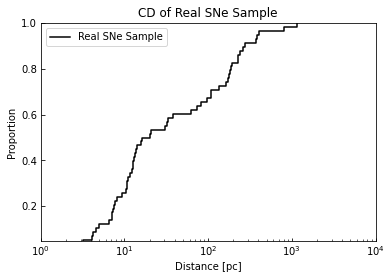

In [10]:
import seaborn as sns

fig = plt.figure(figsize = (6,4))
sns.ecdfplot(nSM,color = "black",  label="Real SNe Sample")
plt.xscale('log')
plt.legend(loc='best')
plt.ylim (0.05,1.0)
plt.xlim(1,10000)
# plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey', ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.title("CD of Real SNe Sample")
plt.xlabel("Distance [pc]")
fig.savefig("../Figures/RealSNeCDFs55.png", dpi=300)
plt.show()
plt.close()

In [15]:
modelResults = Table.read("../Data/AllModels.csv", format = 'csv')

nSMm1 = [x for x in modelResults["n55Mod1"] if math.isnan(x) == False and x >= 0]
nSMm2 = [x for x in modelResults["n55Mod2"] if math.isnan(x) == False and x >= 0]
nSMm3 = [x for x in modelResults["n55Mod3"] if math.isnan(x) == False and x >= 0]
nSMm4 = np.concatenate((nSMm2[0:1914],nSMm3[1914:]))

In [16]:
print(len(nSMm1))
print(len(nSMm2))
print(len(nSMm3))
print(len(nSMm4))

2700
2700
2700
2700


In [177]:
def findNearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def randomPull(modelArr, numSNe=63, numRuns=1000):
    # pull intensity vals at locations of 63 model SNe 1000 times.    
    allPulls = []
    for i in range(numRuns):
        singlePulls = []
        for j in range(numSNe):
            val = np.random.choice(modelArr)
            singlePulls.append(val)
        singlePulls = np.sort(singlePulls)
        allPulls.append(singlePulls)
    # determine 50th percentile array by finding 1000 closest values to each x in model array       
    allPer16Vals, allPer83Vals = [],[]
    for i in range(len(modelArr)):
        SNlocVals = []
        for j in range(numRuns):
            SNlocVals.append(findNearest(allPulls[j], modelArr[i]))
        #now find 16-83rd percentiles from each of these local distributions around x value
        locVals = np.sort(SNlocVals)
        if(np.sum(locVals)==0.0):
            sumVals = locVals
        else:
            sumVals = locVals/np.sum(locVals)
        normVals = np.cumsum(sumVals)
        per16Vals = np.interp(0.16,normVals,locVals)
        allPer16Vals.append(per16Vals)
        per83Vals = np.interp(0.83,normVals,locVals)
        allPer83Vals.append(per83Vals)
    return(allPer16Vals, allPer83Vals)

In [178]:
nSMm1_16, nSMm1_83 = randomPull(nSMm1)
nSMm2_16, nSMm2_83 = randomPull(nSMm2)
nSMm3_16, nSMm3_83 = randomPull(nSMm3)
nSMm4_16, nSMm4_83 = randomPull(nSMm4)

<ipython-input-177-81f857eec473>:29: RuntimeWarning: invalid value encountered in true_divide
  normVals = np.cumsum(locVals)/np.sum(locVals)


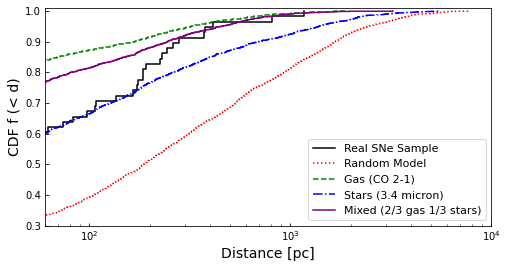

In [181]:

fig = plt.figure(figsize = (8,4))
sns.ecdfplot(nSM,color = "black",  label="Real SNe Sample")
sns.ecdfplot(nSMm1, color = "red", ls = ":", label="Random Model")
sns.ecdfplot(nSMm2, color = "green",ls = "--",  label="Gas (CO 2-1)")
sns.ecdfplot(nSMm3, color = "blue",  ls = "-.",label="Stars (3.4 micron)")
sns.ecdfplot(nSMm4, color = "purple", ls = "-", label="Mixed (2/3 gas 1/3 stars)")
plt.xscale('log')
plt.legend(loc='best', fontsize = 11)
plt.ylim (0.3,1.01)
plt.xlim(60,10000)
plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey',
            ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.xlabel("Distance [pc]", fontsize = 14)
plt.ylabel("CDF f (< d)", fontsize = 14)
fig.savefig("../Figures/ModelCDFs55.png", dpi=300)
plt.show()
plt.close()

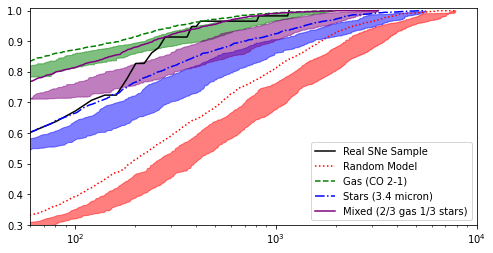

In [180]:
# want to recreate ecdf plot with pyplot

def makeCDFs(array):
    count, bins_count = np.histogram(array, bins=len(array))
    xVals = bins_count[1:]
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return(xVals, cdf)
    
    
SNe,  ySNe  = makeCDFs(nSM)
mod1, ymod1 = makeCDFs(nSMm1)
mod2, ymod2 = makeCDFs(nSMm2)
mod3, ymod3 = makeCDFs(nSMm3)
mod4, ymod4 = makeCDFs(nSMm4)
mod1_16, ymod1_16 = makeCDFs(nSMm1_16)
mod1_83, ymod1_83 = makeCDFs(nSMm1_83)
mod2_16, ymod2_16 = makeCDFs(nSMm2_16)
mod2_83, ymod2_83 = makeCDFs(nSMm2_83)
mod3_16, ymod3_16 = makeCDFs(nSMm3_16)
mod3_83, ymod3_83 = makeCDFs(nSMm3_83)
mod4_16, ymod4_16 = makeCDFs(nSMm4_16)
mod4_83, ymod4_83 = makeCDFs(nSMm4_83)

fig = plt.figure(figsize=(8,4))
plt.xscale('log')
plt.ylim (0.3,1.01)
plt.xlim(60,10000)
plt.plot(SNe, ySNe, label="Real SNe Sample", color='k')
plt.plot(mod1, ymod1, label="Random Model", color='red', ls=":")
plt.plot(mod2, ymod2, label="Gas (CO 2-1)", color='green', ls="--")
plt.plot(mod3, ymod3, label="Stars (3.4 micron)", color='blue', ls="-.")
plt.plot(mod4, ymod4, label="Mixed (2/3 gas 1/3 stars)", color='purple', ls="-")
plt.fill_between(x=mod1, y1=ymod1_16,y2=ymod1_83, color='red', alpha=0.5)
plt.fill_between(x=mod2, y1=ymod2_16,y2=ymod2_83, color='green', alpha=0.5)
plt.fill_between(x=mod3, y1=ymod3_16,y2=ymod3_83, color='blue', alpha=0.5)
plt.fill_between(x=mod4, y1=ymod4_16,y2=ymod4_83, color='purple', alpha=0.5)

plt.legend(loc='best')



In [43]:
# clean arrays of SM values of models and real SN sample
SMm1 = [x for x in modelResults["SigMolMod1"] if math.isnan(x) == False and x >= 0 and x < 10000]
SMm2 = [x for x in modelResults["SigMolMod2"] if math.isnan(x) == False and x >= 0 and x < 10000]
SMm3 = [x for x in modelResults["SigMolMod3"] if math.isnan(x) == False and x >= 0 and x < 10000]
SMm4 = np.concatenate((SMm2[0:1914],SMm3[1914:-1]))


In [19]:
print(SMm3)

[6.3398336396164, 28.401320414176826, 0.0, 7.460021323813065, 318.3154408827361, 22.924220549987133, 0.0, 0.0, 4.9242109910948475, 29.604481048847273, 0.0, 0.0, 11.539512766853315, 0.0, 10.121067724343993, 10.576881922770118, 0.0, 8.997336875733325, 448.62491599789286, 0.0, 5.210557482828718, 0.0, 14.90780769069516, 1.9075787975975063, 1.9523859204453728, 1.8534701553813078, 0.0, 7.9694886232588855, 0.0, 12.084958237375265, 114.47803166973773, 169.42231698423564, 13.758213019194354, 31.867858049129342, 0.0, 14.67537471941423, 28.63435842016386, 0.0, 0.0, 18.067253178771846, 5.311104696264181, 3.8464474431808022, 33.549642156809654, 50.083692867508006, 2.2082907799127436, 1.264488908680218, 4.5582544049232565, 14.899819932594495, 13.118637051025084, 189.8129883088242, 0.0, 23.088917846640037, 47.31793262394, 13.552413393354605, 0.23886494278150242, 15.45955802527876, 0.40530874672311945, 20.949933192299845, 3.5705757836524774, 20.024615672993125, 8.014141631465574, 12.28904852241963, 6.

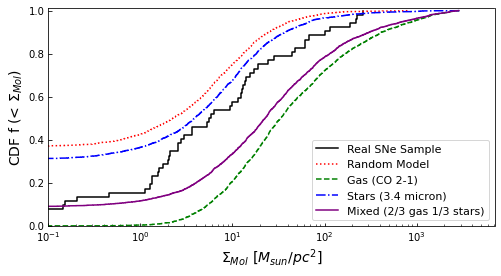

In [25]:

fig = plt.figure(figsize = (8,4))
sns.ecdfplot(SMv,color = "black",  label="Real SNe Sample")
sns.ecdfplot(SMm1, color = "red", ls = ":", label="Random Model")
sns.ecdfplot(SMm2, color = "green",ls = "--",  label="Gas (CO 2-1)")
sns.ecdfplot(SMm3, color = "blue",  ls = "-.",label="Stars (3.4 micron)")
sns.ecdfplot(SMm4, color = "purple", ls = "-", label="Mixed (2/3 gas 1/3 stars)")
plt.xscale('log')
plt.legend(loc='best', fontsize = 11)
plt.ylim (0.0,1.01)
plt.xlim(0.1,7000)
# plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey',ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.xlabel('$\Sigma_{Mol}$ $[M_{sun}/pc^2]$', fontsize = 14)
plt.ylabel('CDF f (< $\Sigma_{Mol}$)', fontsize = 14)
fig.savefig("../Figures/ModelCDFsSM.png", dpi=300)
plt.show()
plt.close()